Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
#train_subset = 10000
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul*tf.nn.l2_loss(weights)
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [8]:
#Lets run this comutation and iterate
num_steps = 3001

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  #tf.global_variables_initializer().run()
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    #pick the offset in the training data which has been radomized.
    # Note: we could use better randomization across epochs
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset+batch_size), :]
    #Prepare a dictionalry telling the session where to feed the minibatch.
    # The key of the dictionary is the is the placeholder node for the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul: 1e-3}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 20.380402
Minibatch accuracy: 13.3%
Validation accuracy: 16.1%
Minibatch loss at step 100: 5.466839
Minibatch accuracy: 69.5%
Validation accuracy: 70.4%
Minibatch loss at step 200: 4.761787
Minibatch accuracy: 68.8%
Validation accuracy: 73.5%
Minibatch loss at step 300: 3.333981
Minibatch accuracy: 81.2%
Validation accuracy: 74.8%
Minibatch loss at step 400: 3.824338
Minibatch accuracy: 68.8%
Validation accuracy: 76.1%
Minibatch loss at step 500: 2.575907
Minibatch accuracy: 75.0%
Validation accuracy: 76.3%
Minibatch loss at step 600: 2.326572
Minibatch accuracy: 77.3%
Validation accuracy: 76.3%
Minibatch loss at step 700: 2.159472
Minibatch accuracy: 82.0%
Validation accuracy: 77.1%
Minibatch loss at step 800: 1.950850
Minibatch accuracy: 77.3%
Validation accuracy: 76.4%
Minibatch loss at step 900: 2.214430
Minibatch accuracy: 75.0%
Validation accuracy: 77.3%
Minibatch loss at step 1000: 2.080764
Minibatch accuracy: 70.3%
Validation accuracy: 77.8

The L2 parameter introduced a meta parameter and since I don't have any idea what would be right value of this parameter I would plot an accuracy 
by the meta parameter value (in log scale)

In [12]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
        # Pick on offset within the training data, which has been randomized
        # Note: we could use better randomization across graph
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        #Generate a minibatch
            batch_data = train_dataset[offset:(offset+batch_size), :]
            batch_labels = train_labels[offset:(offset+batch_size),:]
        # Prepare a dictionary telling the session where to feed the minibatch
        # The key of the dictionary is the placeholder node of the graph to be fed
        # and the value is the numpy array to feed to it
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels : batch_labels, beta_regul : regul}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

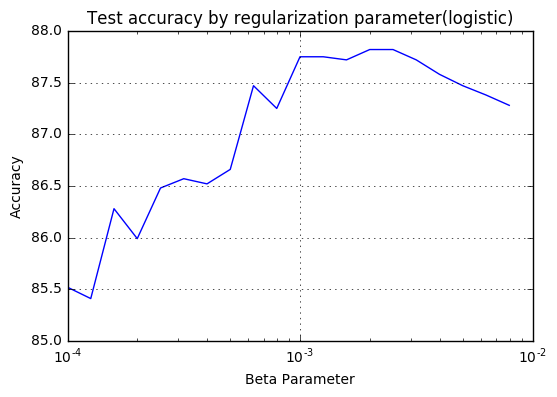

In [13]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.xlabel('Beta Parameter')
plt.ylabel('Accuracy')
plt.title("Test accuracy by regularization parameter(logistic)")
plt.show()

Lets see if the same approach will improve performance of the 1-layer neural network

In [27]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    #Input data. For the training data, we use a placeholder that will be fed
    #at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    #Variables
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    #Training computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
           beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #Prediction for the training, validation and test sets
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)    

In [28]:
#Lets run this comutation and iterate
num_steps = 3001

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    #pick the offset in the training data which has been radomized.
    # Note: we could use better randomization across epochs
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset+batch_size), :]
    #Prepare a dictionalry telling the session where to feed the minibatch.
    # The key of the dictionary is the is the placeholder node for the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul: 1e-3}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 737.856812
Minibatch accuracy: 10.2%
Validation accuracy: 28.0%
Minibatch loss at step 500: 193.145432
Minibatch accuracy: 78.9%
Validation accuracy: 80.4%
Minibatch loss at step 1000: 113.938164
Minibatch accuracy: 75.8%
Validation accuracy: 81.2%
Minibatch loss at step 1500: 68.555458
Minibatch accuracy: 83.6%
Validation accuracy: 83.4%
Minibatch loss at step 2000: 41.568699
Minibatch accuracy: 83.6%
Validation accuracy: 84.4%
Minibatch loss at step 2500: 25.307682
Minibatch accuracy: 85.9%
Validation accuracy: 85.7%
Minibatch loss at step 3000: 15.500218
Minibatch accuracy: 85.9%
Validation accuracy: 86.3%
Test accuracy: 92.8%


First time got accuracy over 90% whew!!!

In [34]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4,-2,0.1)]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph = graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            #Pick an offset within the training data, which is randomized
            #Note: we could use better randomization across epochs
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            #Prepare a dictionary telling the session where to feed the minibatch
            # and value is the numpy array to feed to it
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

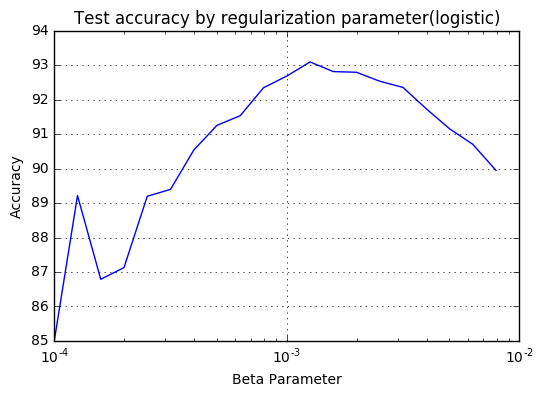

In [35]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.xlabel('Beta Parameter')
plt.ylabel('Accuracy')
plt.title("Test accuracy by regularization parameter(logistic)")
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [36]:
# With gradient descent training, even this much data is prohibitive.
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    #Input data. For the training data, we use a placeholder that will be fed
    #at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    #Variables
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    #Training computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #Prediction for the training, validation and test sets
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2) 

In [38]:
#Lets run this comutation and iterate
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    #pick the offset in the training data which has been radomized.
    # Note: we could use better randomization across epochs
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_batches
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset+batch_size), :]
    #Prepare a dictionalry telling the session where to feed the minibatch.
    # The key of the dictionary is the is the placeholder node for the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul: 1e-3}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 367.239532
Minibatch accuracy: 9.4%
Validation accuracy: 21.9%
Test accuracy: 67.5%


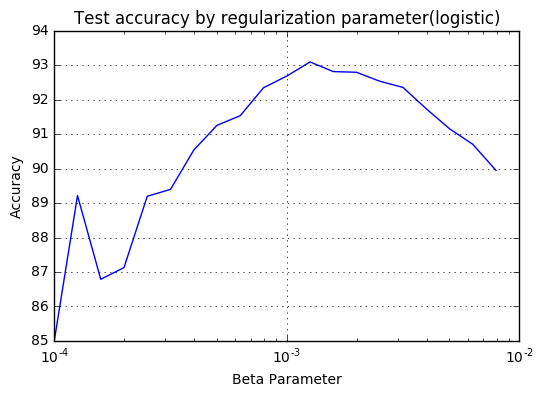

In [39]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.xlabel('Beta Parameter')
plt.ylabel('Accuracy')
plt.title("Test accuracy by regularization parameter(logistic)")
plt.show()

Since there is far too much parameter and no regularization, the accuracy of the batches (training) reached very hight but 
it didn't generalize too well.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [40]:
# With gradient descent training, even this much data is prohibitive.
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    #Input data. For the training data, we use a placeholder that will be fed
    #at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    #Variables
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    #Training computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #Prediction for the training, validation and test sets
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2) 

In [42]:
#Lets run this comutation and iterate
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    #pick the offset in the training data which has been radomized.
    # Note: we could use better randomization across epochs
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #offset = step % num_batches
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset+batch_size), :]
    #Prepare a dictionalry telling the session where to feed the minibatch.
    # The key of the dictionary is the is the placeholder node for the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul: 1e-3}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 461.604187
Minibatch accuracy: 11.7%
Validation accuracy: 16.4%
Test accuracy: 85.0%


Test accuracy has increased because of use of dropout which reduced coadoption properties of activation unit/neurons.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Lets do that first two layers and change how the parameters are initialized, compared to previous cases

In [53]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():
    
    #Input data. For the training data, we use a placeholder that will be fed
    #at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    #Variables
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_nodes1], 
                            stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], 
                            stddev= np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes2, num_labels], 
                            stddev= np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_labels]))
    
    #Training computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)        
    #drop1 = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(lay2_train, weights3) + biases3
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
        beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
    # Optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    #Prediction for the training, validation and test sets
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)        
    valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3) 

In [54]:
#Lets run this comutation and iterate
num_steps = 9001

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    #pick the offset in the training data which has been radomized.
    # Note: we could use better randomization across epochs
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #offset = step % num_batches
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset+batch_size), :]
    #Prepare a dictionalry telling the session where to feed the minibatch.
    # The key of the dictionary is the is the placeholder node for the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.143208
Minibatch accuracy: 21.1%
Validation accuracy: 32.3%
Minibatch loss at step 500: 1.023426
Minibatch accuracy: 85.9%
Validation accuracy: 84.5%
Minibatch loss at step 1000: 1.044920
Minibatch accuracy: 80.5%
Validation accuracy: 87.0%
Minibatch loss at step 1500: 0.623559
Minibatch accuracy: 93.0%
Validation accuracy: 87.8%
Minibatch loss at step 2000: 0.640721
Minibatch accuracy: 89.1%
Validation accuracy: 88.2%
Minibatch loss at step 2500: 0.517430
Minibatch accuracy: 91.4%
Validation accuracy: 88.4%
Minibatch loss at step 3000: 0.551429
Minibatch accuracy: 89.1%
Validation accuracy: 88.9%
Minibatch loss at step 3500: 0.527504
Minibatch accuracy: 91.4%
Validation accuracy: 89.4%
Minibatch loss at step 4000: 0.423207
Minibatch accuracy: 91.4%
Validation accuracy: 89.3%
Minibatch loss at step 4500: 0.559187
Minibatch accuracy: 89.1%
Validation accuracy: 89.7%
Minibatch loss at step 5000: 0.611271
Minibatch accuracy: 89.1%
Validation accurac

This is going great, now try one more layer deeper in the network

In [57]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():
    
    #Input data. For the training data, we use a placeholder that will be fed
    #at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    #Variables
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_nodes1], 
                            stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], 
                            stddev= np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], 
                            stddev= np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    weights4 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes3, num_labels], 
                            stddev= np.sqrt(2.0 / num_hidden_nodes3)))
    biases4 = tf.Variable(tf.zeros([num_labels]))
    #Training computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)   
    lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)        
    
    #drop1 = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(lay3_train, weights4) + biases4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
        beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(weights4))
    # Optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    #Prediction for the training, validation and test sets
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)     
    lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4) 

In [58]:
#Lets run this computation and iterate
num_steps = 18001

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    #pick the offset in the training data which has been radomized.
    # Note: we could use better randomization across epochs
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #offset = step % num_batches
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset+batch_size), :]
    #Prepare a dictionalry telling the session where to feed the minibatch.
    # The key of the dictionary is the is the placeholder node for the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.497494
Minibatch accuracy: 10.2%
Validation accuracy: 20.7%
Minibatch loss at step 500: 1.147982
Minibatch accuracy: 86.7%
Validation accuracy: 83.6%
Minibatch loss at step 1000: 1.089037
Minibatch accuracy: 81.2%
Validation accuracy: 86.5%
Minibatch loss at step 1500: 0.655303
Minibatch accuracy: 92.2%
Validation accuracy: 87.3%
Minibatch loss at step 2000: 0.662725
Minibatch accuracy: 87.5%
Validation accuracy: 87.3%
Minibatch loss at step 2500: 0.526266
Minibatch accuracy: 89.8%
Validation accuracy: 87.1%
Minibatch loss at step 3000: 0.513025
Minibatch accuracy: 89.8%
Validation accuracy: 88.2%
Minibatch loss at step 3500: 0.539301
Minibatch accuracy: 88.3%
Validation accuracy: 88.3%
Minibatch loss at step 4000: 0.414465
Minibatch accuracy: 90.6%
Validation accuracy: 88.3%
Minibatch loss at step 4500: 0.538997
Minibatch accuracy: 88.3%
Validation accuracy: 89.3%
Minibatch loss at step 5000: 0.630841
Minibatch accuracy: 87.5%
Validation accurac

In [60]:
#Now we can increase the width by increasing the number of activation unit in each layer but that won't help
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 512
num_hidden_nodes2 = 256
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():
    
    #Input data. For the training data, we use a placeholder that will be fed
    #at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    #Variables
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_nodes1], 
                            stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], 
                            stddev= np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], 
                            stddev= np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    weights4 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes3, num_labels], 
                            stddev= np.sqrt(2.0 / num_hidden_nodes3)))
    biases4 = tf.Variable(tf.zeros([num_labels]))
    #Training computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)   
    lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)        
    
    #drop1 = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(lay3_train, weights4) + biases4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
        beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(weights4))
    # Optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 5000, 0.80, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    #Prediction for the training, validation and test sets
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)     
    lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4) 

In [61]:
#Lets run this computation and iterate
num_steps = 20001

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    #pick the offset in the training data which has been radomized.
    # Note: we could use better randomization across epochs
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #offset = step % num_batches
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset+batch_size), :]
    #Prepare a dictionalry telling the session where to feed the minibatch.
    # The key of the dictionary is the is the placeholder node for the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.508031
Minibatch accuracy: 8.6%
Validation accuracy: 17.9%
Minibatch loss at step 500: 1.158002
Minibatch accuracy: 85.2%
Validation accuracy: 84.9%
Minibatch loss at step 1000: 1.098492
Minibatch accuracy: 82.0%
Validation accuracy: 86.1%
Minibatch loss at step 1500: 0.661303
Minibatch accuracy: 92.2%
Validation accuracy: 87.4%
Minibatch loss at step 2000: 0.691450
Minibatch accuracy: 84.4%
Validation accuracy: 87.7%
Minibatch loss at step 2500: 0.505425
Minibatch accuracy: 90.6%
Validation accuracy: 87.1%
Minibatch loss at step 3000: 0.541973
Minibatch accuracy: 87.5%
Validation accuracy: 88.3%
Minibatch loss at step 3500: 0.539747
Minibatch accuracy: 89.1%
Validation accuracy: 88.6%
Minibatch loss at step 4000: 0.436021
Minibatch accuracy: 89.8%
Validation accuracy: 88.5%
Minibatch loss at step 4500: 0.564675
Minibatch accuracy: 89.1%
Validation accuracy: 88.4%
Minibatch loss at step 5000: 0.663260
Minibatch accuracy: 87.5%
Validation accuracy